In [1]:
import os
import datetime
import pandas as pd
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
from scipy import stats
from tqdm import tqdm
import pickle
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from glob import glob

sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})

# TODO: your wandb API key
os.environ["WANDB_API_KEY"] = ""


def average_df_series(series):
    # Initialize an accumulator DataFrame for sums
    sum_df = None
    # Number of DataFrames in the series
    n = len(series)

    for df in series:
        # If sum_df is None, initialize it with the first DataFrame
        if sum_df is None:
            sum_df = df.copy()
        else:
            # Otherwise, add the current DataFrame to the sum_df
            sum_df += df

    # Divide each value by n to get the average
    average_df = sum_df / n
    return average_df


def get_runs(filters, proj="struct_mlp", tune_on="test", avg_seeds=True, history=True):
    api = wandb.Api()
    runs = api.runs(proj, filters=filters, order="-created_at")
    summary_list, config_list, name_list = [], [], []
    history_list = []
    for run in runs:
        summary_list.append(run.summary._json_dict)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append({k: v for k, v in run.config.items() if not k.startswith("_")})

        # .name is the human-readable name of the run.
        name_list.append(run.name)
        if history:
            if "train_loss_avg" in run.summary._json_dict:
                hist = run._sampled_history(keys=["current_compute", "train_loss_avg"], x_axis="step", samples=1000)
            else:
                hist = run._sampled_history(keys=["compute", "val/loss"], x_axis="iter", samples=1000)
            hist_df = pd.DataFrame(hist)
            history_list.append(hist_df)

    runs_dict = {
        "summary": summary_list,
        "config": config_list,
        "name": name_list,
    }
    if history:
        runs_dict["history"] = history_list
    runs_df = pd.DataFrame(runs_dict)

    runs_df = runs_df[runs_df["summary"].apply(lambda x: x != {})]
    keys = [
        "width",
        "depth",
        "struct",
        "cola_params",
        "cola_flops",
        "lr",
        "batch_size",
        "tt_rank",
        "expr",
        "num_experts",
        "num_active_experts",
        "num_ffn_experts",
        # "_runtime"
    ]
    for key in keys:
        # For other keys, just extract the value if it exists
        runs_df[key] = runs_df["config"].apply(lambda x: x[key] if key in x else -1)

    for key in ["train_loss_avg", "current_compute", "val/loss", "step", "iter", "epoch"]:
        runs_df[key] = runs_df["summary"].apply(lambda x: x[key] if key in x else -1)
    # runs_df["runtime"] = runs_df["_runtime"].apply(lambda x: x / 60)  # convert to minutes

    # delete name summary and config
    runs_df = runs_df.drop(columns=["summary", "config", "name"])

    # Everything else being equal, only keep the best run
    if tune_on is not None:
        if "loss" in tune_on:
            idx = runs_df.groupby(keys)[tune_on].idxmin()
        else:
            idx = runs_df.groupby(keys)[tune_on].idxmax()
        runs_df = runs_df.loc[idx]

    # average over seeds
    if avg_seeds:
        keys = [k for k in keys if k != "seed"]
        numeric_cols = runs_df.select_dtypes(include=[np.number]).columns.tolist()
        agg_dict = {col: "mean" for col in numeric_cols}
        agg_dict.update({col: "first" for col in keys})
        if history:
            agg_dict["history"] = average_df_series

        runs_df = runs_df.groupby(keys).agg(agg_dict).reset_index(drop=True)
    # Tune LR
    if tune_on is not None:
        # remove lr
        keys = [k for k in keys if k != "lr"]
        if "loss" in tune_on:
            idx = runs_df.groupby(keys)[tune_on].idxmin()
        else:
            idx = runs_df.groupby(keys)[tune_on].idxmax()
        runs_df = runs_df.loc[idx]
    return runs_df

def get_vec(row):
    if row["struct"].lower() == "dense":
        return "Dense"
    expr = row["expr"][1:-1]
    vec = expr.split("|") if "|" in expr else expr.split("-")
    # turn into float
    vec = [float(x) for x in vec]
    # reorder
    if "|" in expr:
        fixed_indices = [0, 1, 2, 6, 3, 4, 5]
    else:
        fixed_indices = [1, 0, 2, 3, 5, 4, 6]
    # a b c r d e f
    vec = [vec[i] for i in fixed_indices]
    a, b, c, r, d, e, f = vec
    if not min(a, e) >= min(b, d):
        print(f"Vector {vec} is redundant!")
        return (0, 0, 0, 0, 0, 0, 0)
    if not r <= min(a, e):
        print(f"Vector {vec} is degenerate!")
        return (0, 0, 0, 0, 0, 0, 0)
    return tuple(vec)


def cleanup_expr(row):
    if "|" in row["expr"]:
        expr = row["expr"][1:-1].replace("|", ",")
    else:
        expr = row["expr"][1:-1].replace("-", ",")
    coeffs = expr.split(",")
    if float(coeffs[0]) > 0:
        fixed_indices = [0, 1, 2, 6, 3, 4, 5]
    else:
        fixed_indices = [1, 0, 2, 3, 5, 4, 6]
    coeffs = [coeffs[i] for i in fixed_indices]
    coeffs = [str(int(float(x))) if float(x).is_integer() else str(x) for x in coeffs]
    expr = ",".join(coeffs)
    fraction_map = {0.25: "\\frac{1}{4}", 0.33: "\\frac{1}{3}", 0.5: "\\frac{1}{2}", 0.67: "\\frac{2}{3}", 0.75: "\\frac{3}{4}"}
    for key, value in fraction_map.items():
        expr = expr.replace(str(key), value)
    expr = "$(" + expr + ")$"

    return expr


def vec_to_omega(vec):
    a, b, c, r, d, e, f = vec
    # omega = min(a+d, b+e) - min(a, e)
    if str(vec).lower() == "dense":
        return 0
    return min(vec[0] + vec[4], vec[1] + vec[5]) - min(vec[0], vec[5])
    min(a + d, b + e) - min(a, e)


def vec_to_psi(vec):
    # psi = min(r + d + f - a, b + c + r - e)
    a, b, c, r, d, e, f = vec
    return 1 + min(0, 1 + r - a - e)


def vec_to_nu(vec):
    # nu = 1 + r - min(a,e)
    return 1 + vec[3] - min(vec[0], vec[5])


def get_omega(row):
    if str(row['vec']).lower() == "dense":
        return 0
    vec = row["vec"]  # alpha/a beta/b gamma/c rho/r delta/d eps/e phi/f
    return vec_to_omega(vec)


def get_psi(row):
    if str(row['vec']).lower() == "dense":
        return 1
    vec = row["vec"]  # a b c r d e f
    return vec_to_psi(vec)


def get_nu(row):
    if str(row['vec']).lower() == "dense":
        return 1
    vec = row["vec"]  # a b c r d e f
    # nu = 1 + r - min(a,e)
    return vec_to_nu(vec)


import numpy as np
from scipy.optimize import linprog, curve_fit
from scipy.spatial import ConvexHull


def fit_power_law(df, min_compute=0, max_compute=1e32):
    log_compute = np.log(df["compute"])
    log_loss = np.log(df["loss"])

    # Filter out points that are outside the range
    valid = (df["compute"] >= min_compute) & (df["compute"] <= max_compute)
    log_compute = log_compute[valid]
    log_loss = log_loss[valid]

    # Set up the objective coefficients
    c = -np.array([np.sum(-log_compute), len(log_compute)])

    # Set up the constraint matrix and vector
    A_ub = np.column_stack((-log_compute, np.ones(len(log_compute))))
    b_ub = log_loss

    # Solve the linear programming problem
    result = linprog(c, A_ub=A_ub, b_ub=b_ub, method="highs", bounds=(None, None))

    # Extract the optimal parameters
    a_opt, b_opt = result.x

    return a_opt, b_opt


def get_pareto_front(df, threshold=0.02):
    # Convert 'compute' and 'loss' to logarithmic scale
    log_compute = np.log(df["compute"])
    log_loss = np.log(df["loss"])

    # Create an array of points in the log-log space
    points = np.column_stack((log_compute, log_loss))

    # Add (max x, max y) to the convex hull
    points = np.vstack((points, [np.max(log_compute) + 1, np.max(log_loss) + 1]))

    # Find the convex hull of the points
    hull = ConvexHull(points)

    # Get the indices of the points forming the convex hull
    pareto_indices = hull.vertices
    pareto_indices = pareto_indices[pareto_indices < len(df)]

    # Extract the corresponding rows from the original DataFrame
    pareto_front = df.iloc[pareto_indices]

    # Sort the Pareto front based on 'compute'
    pareto_front = pareto_front.sort_values("compute")

    # Interpolate the loss values for all points in the DataFrame
    interpolated_loss = np.interp(log_compute, np.log(pareto_front["compute"]), np.log(pareto_front["loss"]))

    # Calculate the relative difference between the interpolated loss and the actual loss
    relative_diff = np.exp(log_loss - interpolated_loss) - 1

    # Find the indices of points within the threshold
    threshold_indices = np.where(relative_diff <= threshold)[0]

    # Add the points within the threshold to the Pareto front
    pareto_front = pd.concat([pareto_front, df.iloc[threshold_indices]])

    # Remove duplicate points
    pareto_front = pareto_front.drop_duplicates()

    return pareto_front


def improve_pareto_front(df):
    # remove points where dy/dx is positive
    pareto_df = df.sort_values("compute")
    pareto_df = pareto_df.reset_index(drop=True)
    pareto_df["dy"] = pareto_df["loss"].diff()
    pareto_df["dx"] = pareto_df["compute"].diff()
    pareto_df["dy/dx"] = pareto_df["dy"] / pareto_df["dx"]
    pareto_df = pareto_df[pareto_df["dy/dx"] < 0]
    # append first point
    pareto_df = pd.concat([pareto_df, df.iloc[0:1]])
    return pareto_df


def fit_power_law_with_offset(df, xname, yname):
    # Fit a power law with an offset
    x = df[xname]
    y = df[yname]
    x_scale = x.max()
    y_scale = y.max()
    x_scaled = x / x_scale
    y_scaled = y / y_scale

    # Fit a power law with an offset
    def power_law_with_offset(x, a, b, c):
        return a + b * x ** (-c)

    popt, _ = curve_fit(power_law_with_offset, x_scaled, y_scaled)
    a, b, c = popt
    # rescale
    a *= y_scale
    b *= y_scale * (x_scale**c)
    return a, b, c


def fit_power_law_log_log(df, xname, yname, drop_outliner=True):
    x = df[xname]
    y = df[yname]
    log_x = np.log(x)
    log_y = np.log(y)

    mask = np.ones_like(x, dtype=bool)
    if drop_outliner:
        # Find the optimal x_max cutoff by pruning individual large values
        best_r_squared = -float("inf")
        best_m, best_b, best_dm, best_db = None, None, None, None

        for i in range(len(x) - 1, -1, -1):
            mask[i] = False
            result = stats.linregress(log_x[mask], log_y[mask])
            r_squared = result.rvalue**2

            if r_squared > best_r_squared:
                best_r_squared = r_squared
                best_m, best_b = -result.slope, result.intercept
                best_dm, best_db = result.stderr, result.intercept_stderr
            else:
                mask[i] = True
                break

        return best_m, best_b, best_dm, best_db, mask
    else:
        # Fit a linear regression on the entire data
        result = stats.linregress(log_x, log_y)
        m, b = -result.slope, result.intercept
        dm, db = result.stderr, result.intercept_stderr
        return m, b, dm, db, mask


def get_history_df(df, min_step=0, max_step=1e6, min_compute=0, max_compute=1e32, fit=True, min_loss=0, drop_outliner=True):
    run_keys = [
        "cola_flops",
        # "current_compute",
        "non_emb_flops",
        "cola_params",
        "depth",
        "width",
        "struct",
        "lr",
        "num_experts",
        "num_active_experts",
        "num_ffn_experts",
        "num_active_ffn_experts",
        "d_model",
        "n_layer",
        "head_btt_case_qkv",
        "head_btt_case_proj",
        "head_btt_case",
        "vec",
        "omega",
        "psi",
        "nu",
        "name",
    ]
    hist_points = []

    # for run
    for _, row in df.iterrows():
        hist_dict = {k: row[k] if k in row else -1 for k in run_keys}
        non_emb_frac = 1 #hist_dict["non_emb_flops"] / hist_dict["current_compute"]

        # for step
        for step, compute, loss in row["history"]:
            if step < min_step or step > max_step:
                continue

            hist_point = hist_dict.copy()
            hist_point.update({"step": step, "compute": compute * non_emb_frac, "loss": loss - min_loss})
            # hist_point["log_cola_flops"] = np.log(hist_point["current_compute"])
            hist_points.append(hist_point)

    hist_df = pd.DataFrame(hist_points)
    steps_to_keep = list(range(0, 1000_000, 10000))
    hist_df = hist_df[hist_df["step"].isin(steps_to_keep)]
    
    # hist_df["compute"] = hist_df["current_compute"]
    pareto_df = get_pareto_front(hist_df)
    pareto_df = improve_pareto_front(pareto_df)
    if fit:
        # filter based on min and max compute
        fit_df = pareto_df[(pareto_df["compute"] >= min_compute) & (pareto_df["compute"] <= max_compute)]
        # print(fit_df)
        slope, intercept, dslope, dintercept, mask = fit_power_law_log_log(
            fit_df,
            xname="compute",
            yname="loss",
            drop_outliner=False,
        )
        pareto_df = fit_df[mask]
    else:
        slope, intercept, dslope, dintercept = 0, 0, 0, 0
    return hist_df, pareto_df, slope, intercept, dslope, dintercept


def name_map(row, label_experts=True):
    name = row["struct"]
    num_experts = row["num_experts"]
    num_ffn_experts = row["num_ffn_experts"]
    if name == "dense":
        if num_ffn_experts > 1:
            return f"Std. MoE" + (f"-{num_ffn_experts}" if label_experts else "")
        else:
            return "Dense"
    elif name == "dense_moe":
        return f"Dense-MoE" + (-f"e{num_experts}" if label_experts else "")
    elif name == "btt_norm_moe":
        return "BTT-MoE v0"
    elif name == "btt_norm_moe_para":
        return "BTT-MoE"
    elif name.startswith("btt_norm"):
        return name.replace("btt_norm", f'BTT Rank-{row["tt_rank"]}')
    elif name in ["einsum_norm", "einsum"]:
        return cleanup_expr(row)
    return name


In [2]:
filters = {
    "config.struct": {"$in": ["dense"]},
    "config.layers": {"$in": ['all_but_last']},
    "config.model": {"$eq": 'MLP'},
    "config.input_dim": 8,
    "config.depth": 3,
    "config.steps": 1e6,
}
# TODO: your project name
runs = get_runs(filters, proj="TODO", tune_on='train_loss_avg', history=True, avg_seeds=True)
runs["struct"] = runs.apply(name_map, label_experts=False, axis=1)
dense_runs = runs[runs["struct"] == "Dense"]
dense_runs['vec'] = dense_runs.apply(get_vec, axis=1)


filters = {
    "config.struct": {"$in": ["einsum", "einsum_norm"]},
    "config.layers": {"$in": ['intermediate']},
    "config.model": {"$eq": 'MLP'},
    "config.input_dim": 8,
    "config.depth": 3,
    "config.steps": 1e6,
}
plot_name = "synthetic"
ein_runs = get_runs(filters, proj="ap-team/synth", tune_on='train_loss_avg', history=True, avg_seeds=True)
ein_runs['struct'] = ein_runs.apply(name_map, axis=1)
ein_runs["vec"] = ein_runs.apply(get_vec, axis=1)
ein_runs = ein_runs[ein_runs["vec"] != (0, 0, 0, 0, 0, 0, 0)]


dense_runs['omega'] = dense_runs.apply(get_omega, axis=1)
ein_runs['omega'] = ein_runs.apply(get_omega, axis=1)
dense_runs['psi'] = dense_runs.apply(get_psi, axis=1)
ein_runs['psi'] = ein_runs.apply(get_psi, axis=1)
dense_runs['nu'] = dense_runs.apply(get_nu, axis=1)
ein_runs['nu'] = ein_runs.apply(get_nu, axis=1)

Vector [0.0, 1.0, 0.0, 0.75, 1.0, 0.0, 0.0] is redundant!
Vector [0.0, 1.0, 0.0, 0.75, 1.0, 0.0, 0.0] is redundant!
Vector [0.0, 1.0, 0.0, 0.75, 1.0, 0.0, 0.0] is redundant!
Vector [0.0, 1.0, 0.0, 0.75, 1.0, 0.0, 0.0] is redundant!
Vector [0.0, 1.0, 0.0, 0.75, 1.0, 0.0, 0.0] is redundant!
Vector [0.0, 1.0, 0.0, 0.75, 1.0, 0.0, 0.0] is redundant!
Vector [0.0, 1.0, 0.0, 0.75, 1.0, 0.0, 0.0] is redundant!
Vector [0.0, 1.0, 0.0, 0.75, 1.0, 0.0, 0.0] is redundant!
Vector [0.0, 1.0, 0.0, 0.75, 1.0, 0.0, 0.0] is redundant!


$(\frac{1}{2},\frac{1}{2},0,0,0,\frac{1}{2},\frac{1}{2})$


/tmp/ipykernel_12086/3010493432.py:65: UserWarning: 
The palette list has fewer values (1) than needed (270) and will cycle, which may produce an uninterpretable plot.
  ax = sns.lineplot(
/tmp/ipykernel_12086/3010493432.py:80: UserWarning: 
The palette list has fewer values (1) than needed (293) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


<Figure size 800x600 with 0 Axes>

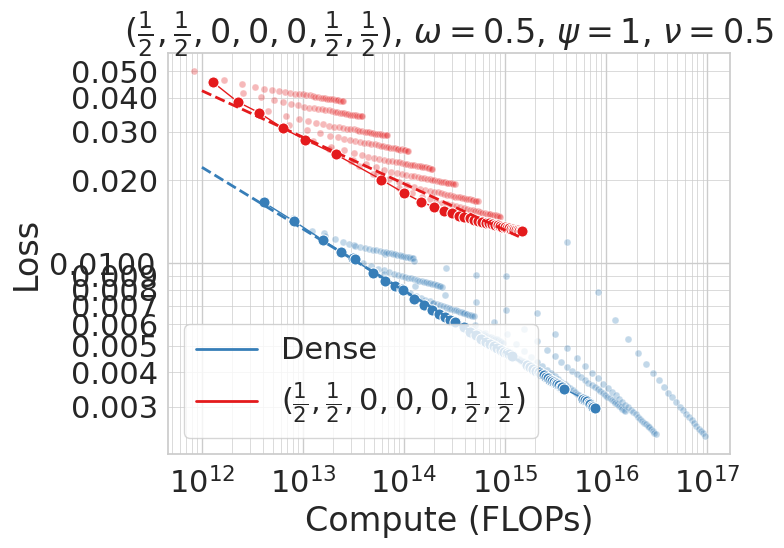

$(\frac{1}{2},\frac{1}{2},0,0,\frac{1}{2},\frac{1}{2},\frac{1}{2})$


/tmp/ipykernel_12086/3010493432.py:65: UserWarning: 
The palette list has fewer values (1) than needed (270) and will cycle, which may produce an uninterpretable plot.
  ax = sns.lineplot(
/tmp/ipykernel_12086/3010493432.py:80: UserWarning: 
The palette list has fewer values (1) than needed (293) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


<Figure size 800x600 with 0 Axes>

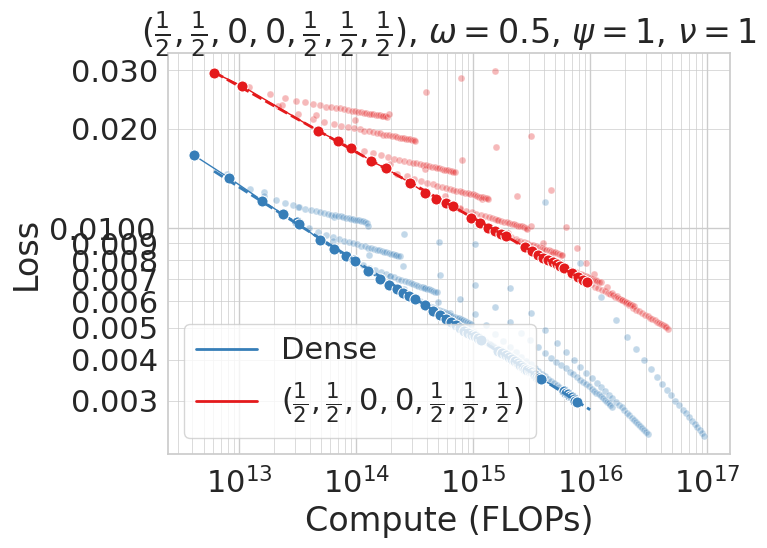

$(1,0,0,\frac{1}{2},0,1,0)$


/tmp/ipykernel_12086/3010493432.py:65: UserWarning: 
The palette list has fewer values (1) than needed (270) and will cycle, which may produce an uninterpretable plot.
  ax = sns.lineplot(
/tmp/ipykernel_12086/3010493432.py:80: UserWarning: 
The palette list has fewer values (1) than needed (293) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


<Figure size 800x600 with 0 Axes>

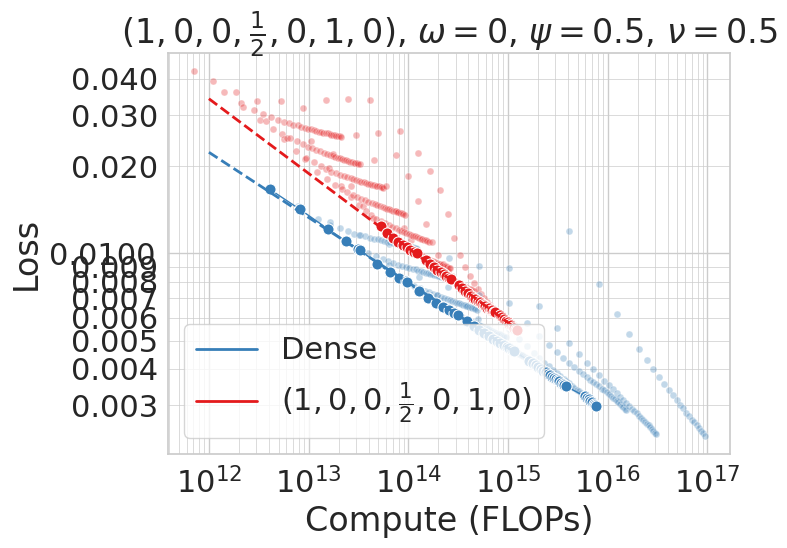

$(\frac{1}{2},0,\frac{1}{2},0,0,\frac{1}{2},\frac{1}{2})$


/tmp/ipykernel_12086/3010493432.py:65: UserWarning: 
The palette list has fewer values (1) than needed (311) and will cycle, which may produce an uninterpretable plot.
  ax = sns.lineplot(
/tmp/ipykernel_12086/3010493432.py:80: UserWarning: 
The palette list has fewer values (1) than needed (293) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


<Figure size 800x600 with 0 Axes>

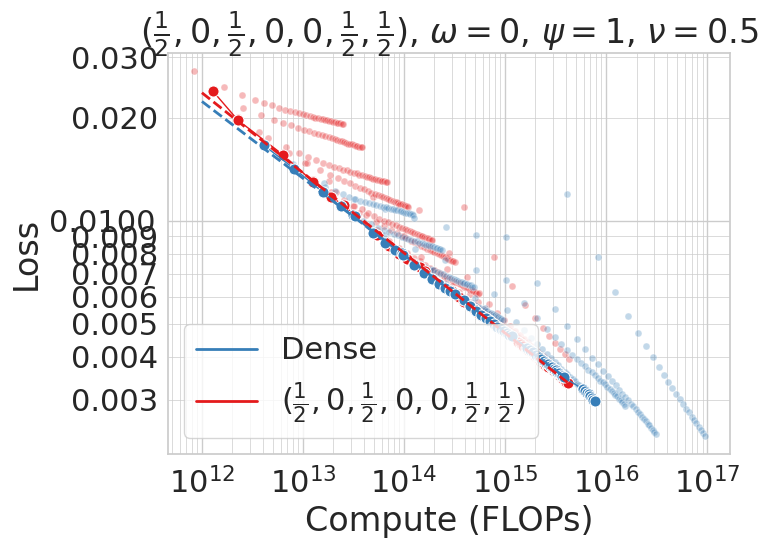

$(\frac{1}{2},0,\frac{1}{2},0.2,0,\frac{1}{2},\frac{1}{2})$


/tmp/ipykernel_12086/3010493432.py:65: UserWarning: 
The palette list has fewer values (1) than needed (27) and will cycle, which may produce an uninterpretable plot.
  ax = sns.lineplot(
/tmp/ipykernel_12086/3010493432.py:80: UserWarning: 
The palette list has fewer values (1) than needed (293) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


<Figure size 800x600 with 0 Axes>

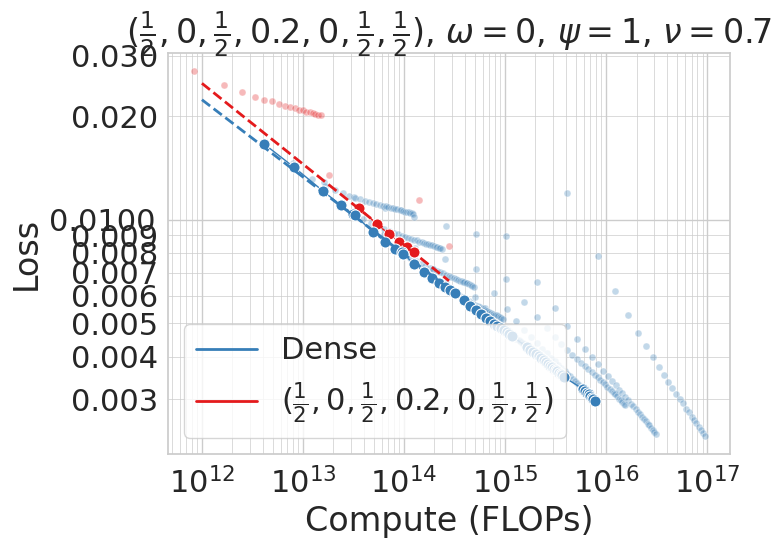

$(\frac{1}{3},0,\frac{2}{3},0,0,\frac{2}{3},\frac{1}{3})$


/tmp/ipykernel_12086/3010493432.py:65: UserWarning: 
The palette list has fewer values (1) than needed (300) and will cycle, which may produce an uninterpretable plot.
  ax = sns.lineplot(
/tmp/ipykernel_12086/3010493432.py:80: UserWarning: 
The palette list has fewer values (1) than needed (293) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


<Figure size 800x600 with 0 Axes>

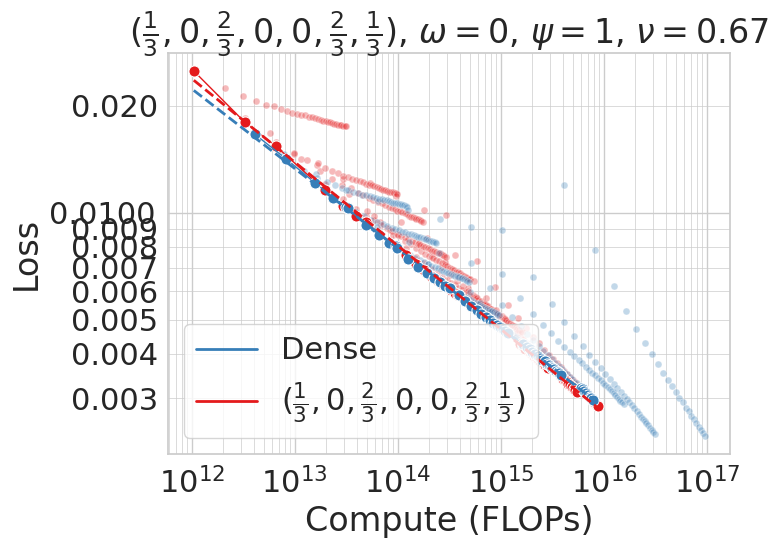

$(\frac{2}{3},0,\frac{1}{3},0,0,\frac{1}{3},\frac{2}{3})$


/tmp/ipykernel_12086/3010493432.py:65: UserWarning: 
The palette list has fewer values (1) than needed (250) and will cycle, which may produce an uninterpretable plot.
  ax = sns.lineplot(
/tmp/ipykernel_12086/3010493432.py:80: UserWarning: 
The palette list has fewer values (1) than needed (293) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


<Figure size 800x600 with 0 Axes>

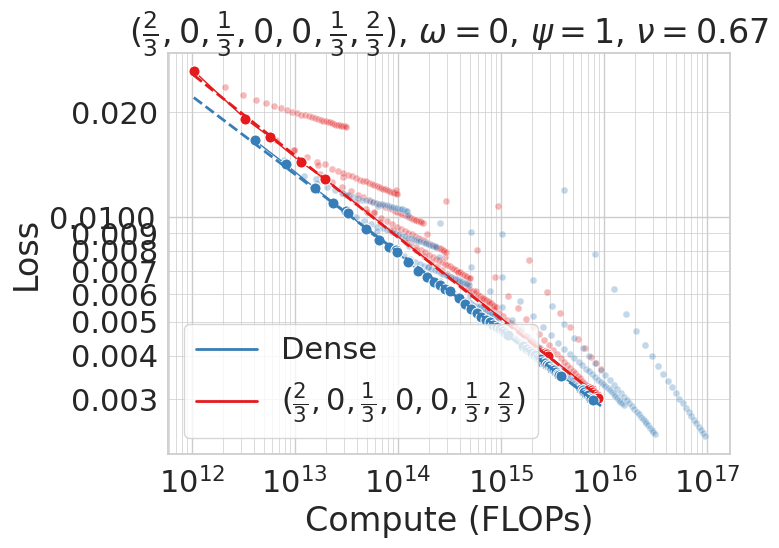

$(\frac{2}{3},0,\frac{1}{3},\frac{1}{4},0,\frac{2}{3},\frac{1}{3})$


/tmp/ipykernel_12086/3010493432.py:65: UserWarning: 
The palette list has fewer values (1) than needed (270) and will cycle, which may produce an uninterpretable plot.
  ax = sns.lineplot(
/tmp/ipykernel_12086/3010493432.py:80: UserWarning: 
The palette list has fewer values (1) than needed (293) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


<Figure size 800x600 with 0 Axes>

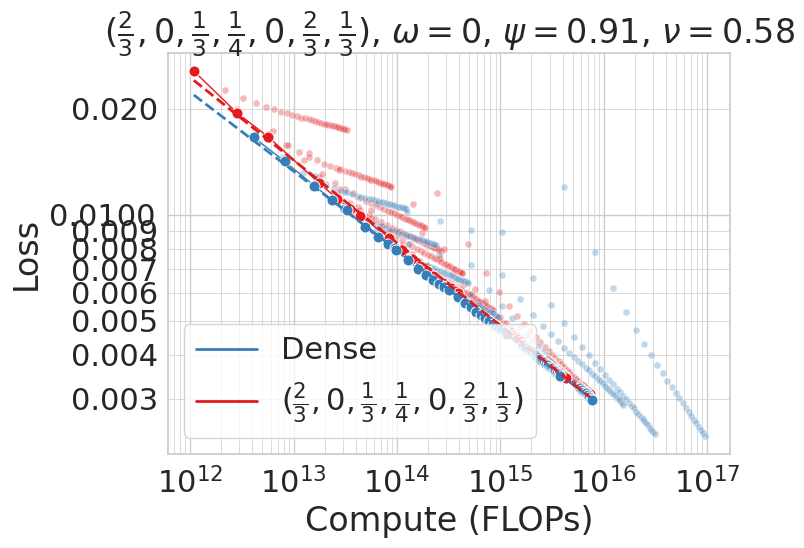

$(\frac{1}{4},0,\frac{3}{4},0,0,\frac{3}{4},\frac{1}{4})$


/tmp/ipykernel_12086/3010493432.py:65: UserWarning: 
The palette list has fewer values (1) than needed (300) and will cycle, which may produce an uninterpretable plot.
  ax = sns.lineplot(
/tmp/ipykernel_12086/3010493432.py:80: UserWarning: 
The palette list has fewer values (1) than needed (293) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


<Figure size 800x600 with 0 Axes>

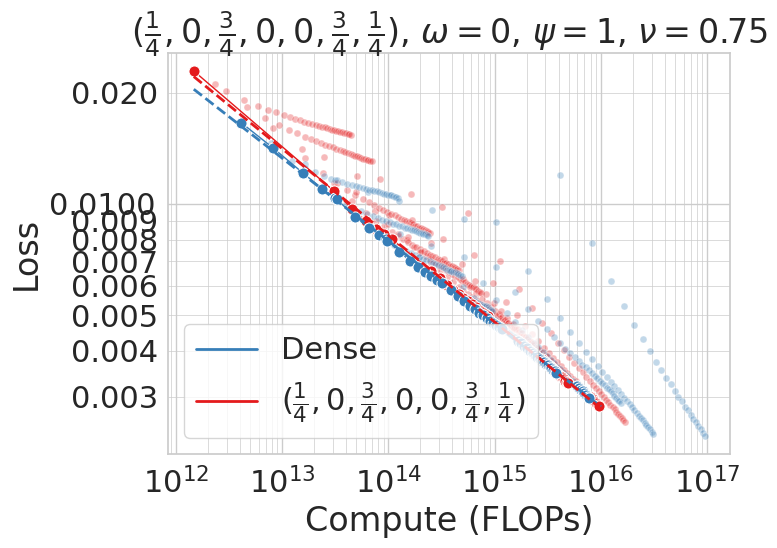

$(\frac{3}{4},0,\frac{1}{4},0,0,\frac{1}{4},\frac{3}{4})$


/tmp/ipykernel_12086/3010493432.py:65: UserWarning: 
The palette list has fewer values (1) than needed (240) and will cycle, which may produce an uninterpretable plot.
  ax = sns.lineplot(
/tmp/ipykernel_12086/3010493432.py:80: UserWarning: 
The palette list has fewer values (1) than needed (293) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


<Figure size 800x600 with 0 Axes>

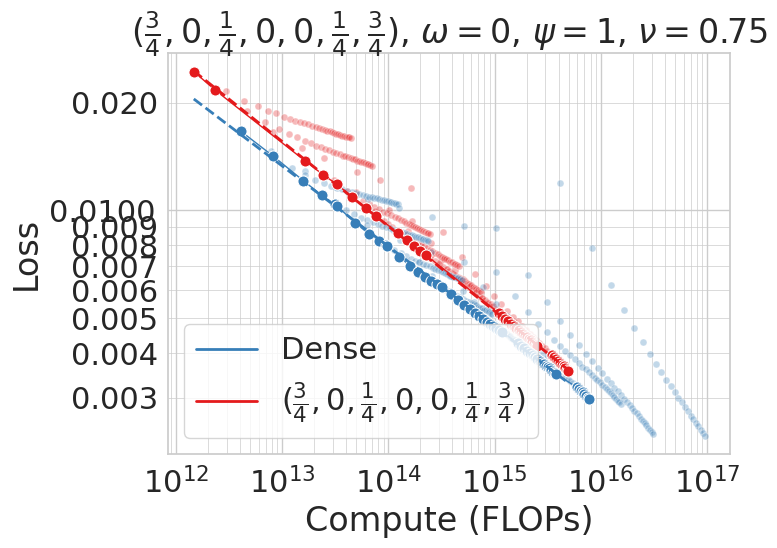

$(\frac{1}{3},0,\frac{2}{3},0,0,\frac{1}{3},\frac{2}{3})$


/tmp/ipykernel_12086/3010493432.py:65: UserWarning: 
The palette list has fewer values (1) than needed (189) and will cycle, which may produce an uninterpretable plot.
  ax = sns.lineplot(
/tmp/ipykernel_12086/3010493432.py:80: UserWarning: 
The palette list has fewer values (1) than needed (293) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


<Figure size 800x600 with 0 Axes>

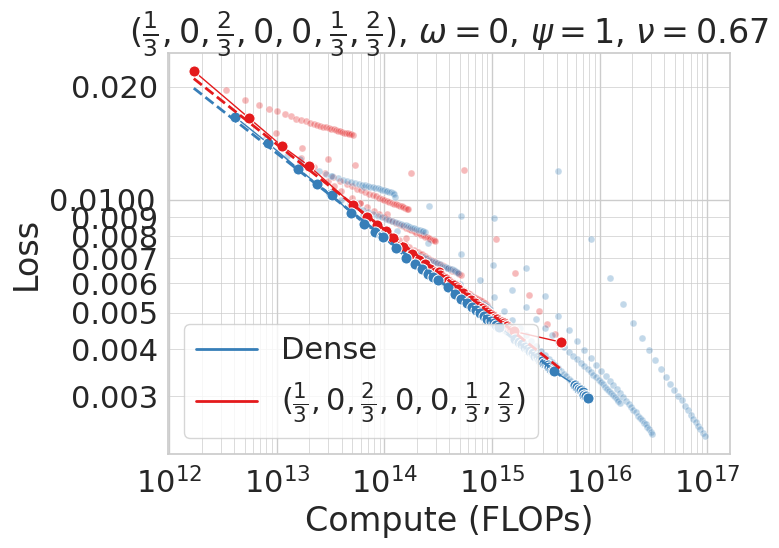

$(1,0,0,\frac{3}{4},0,1,0)$


/tmp/ipykernel_12086/3010493432.py:65: UserWarning: 
The palette list has fewer values (1) than needed (270) and will cycle, which may produce an uninterpretable plot.
  ax = sns.lineplot(
/tmp/ipykernel_12086/3010493432.py:80: UserWarning: 
The palette list has fewer values (1) than needed (293) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


<Figure size 800x600 with 0 Axes>

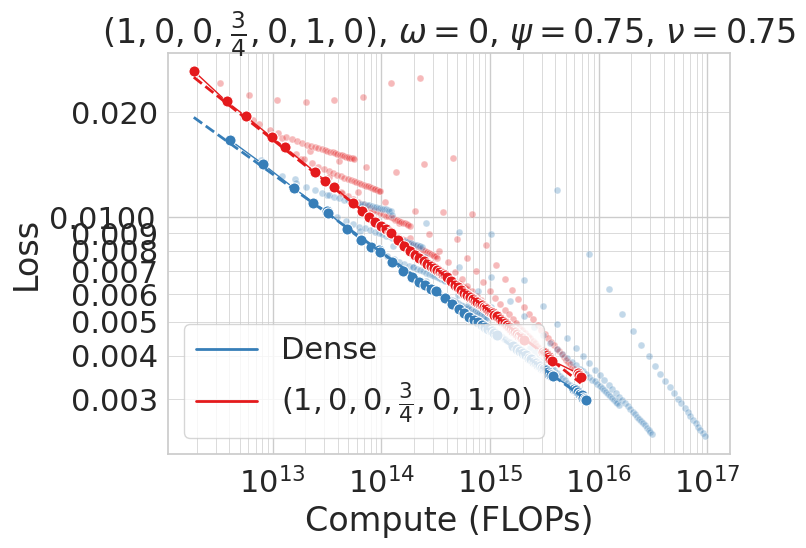

$(\frac{1}{2},0,\frac{1}{2},\frac{1}{4},0,\frac{1}{2},\frac{1}{2})$


/tmp/ipykernel_12086/3010493432.py:65: UserWarning: 
The palette list has fewer values (1) than needed (300) and will cycle, which may produce an uninterpretable plot.
  ax = sns.lineplot(
/tmp/ipykernel_12086/3010493432.py:80: UserWarning: 
The palette list has fewer values (1) than needed (293) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


<Figure size 800x600 with 0 Axes>

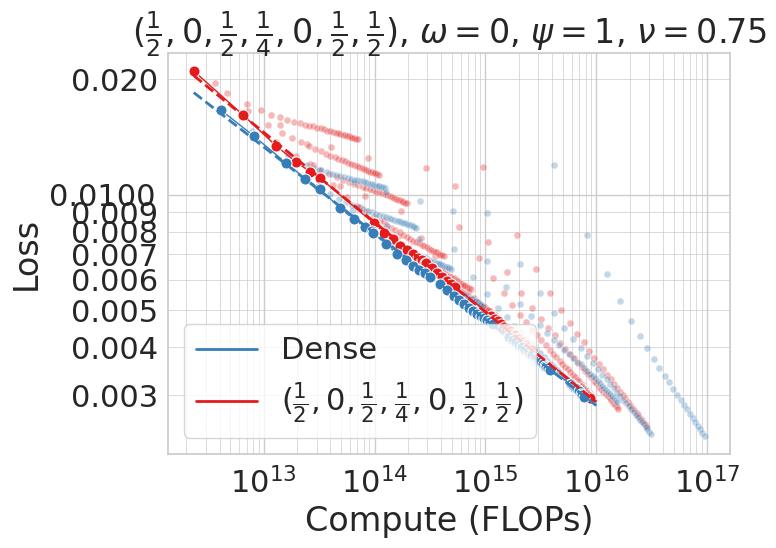

$(\frac{1}{3},0,\frac{2}{3},\frac{1}{4},0,\frac{2}{3},\frac{1}{3})$


/tmp/ipykernel_12086/3010493432.py:65: UserWarning: 
The palette list has fewer values (1) than needed (300) and will cycle, which may produce an uninterpretable plot.
  ax = sns.lineplot(
/tmp/ipykernel_12086/3010493432.py:80: UserWarning: 
The palette list has fewer values (1) than needed (293) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


<Figure size 800x600 with 0 Axes>

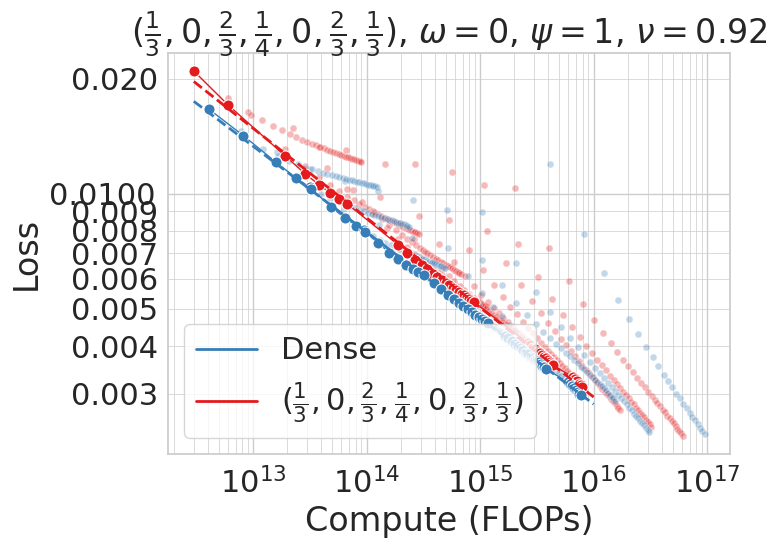

$(\frac{2}{3},0,\frac{1}{3},\frac{1}{4},0,\frac{1}{3},\frac{2}{3})$


/tmp/ipykernel_12086/3010493432.py:65: UserWarning: 
The palette list has fewer values (1) than needed (213) and will cycle, which may produce an uninterpretable plot.
  ax = sns.lineplot(
/tmp/ipykernel_12086/3010493432.py:80: UserWarning: 
The palette list has fewer values (1) than needed (293) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


<Figure size 800x600 with 0 Axes>

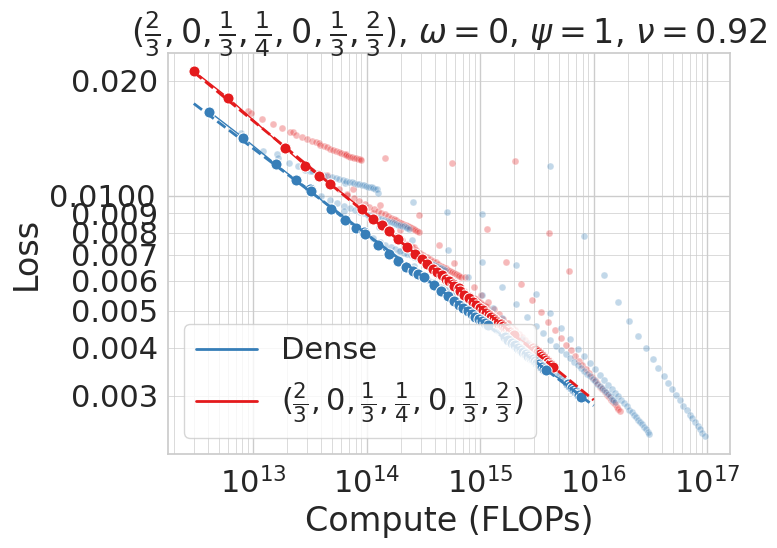

$(\frac{1}{3},0,\frac{2}{3},\frac{1}{4},0,\frac{1}{3},\frac{2}{3})$


/tmp/ipykernel_12086/3010493432.py:65: UserWarning: 
The palette list has fewer values (1) than needed (182) and will cycle, which may produce an uninterpretable plot.
  ax = sns.lineplot(
/tmp/ipykernel_12086/3010493432.py:80: UserWarning: 
The palette list has fewer values (1) than needed (293) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


<Figure size 800x600 with 0 Axes>

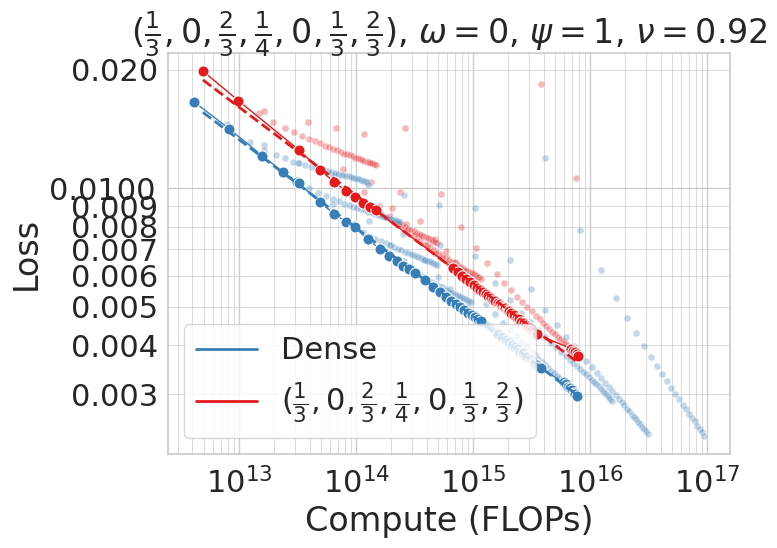

$(\frac{3}{4},0,\frac{1}{4},0,0,\frac{3}{4},\frac{1}{4})$


/tmp/ipykernel_12086/3010493432.py:65: UserWarning: 
The palette list has fewer values (1) than needed (180) and will cycle, which may produce an uninterpretable plot.
  ax = sns.lineplot(
/tmp/ipykernel_12086/3010493432.py:80: UserWarning: 
The palette list has fewer values (1) than needed (293) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


<Figure size 800x600 with 0 Axes>

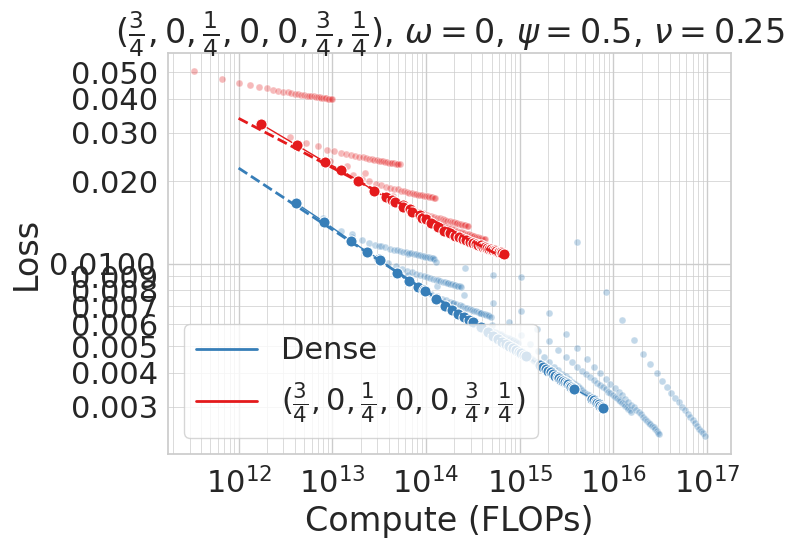

$(\frac{2}{3},0,\frac{1}{3},0,0,\frac{2}{3},\frac{1}{3})$


/tmp/ipykernel_12086/3010493432.py:65: UserWarning: 
The palette list has fewer values (1) than needed (210) and will cycle, which may produce an uninterpretable plot.
  ax = sns.lineplot(
/tmp/ipykernel_12086/3010493432.py:80: UserWarning: 
The palette list has fewer values (1) than needed (293) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


<Figure size 800x600 with 0 Axes>

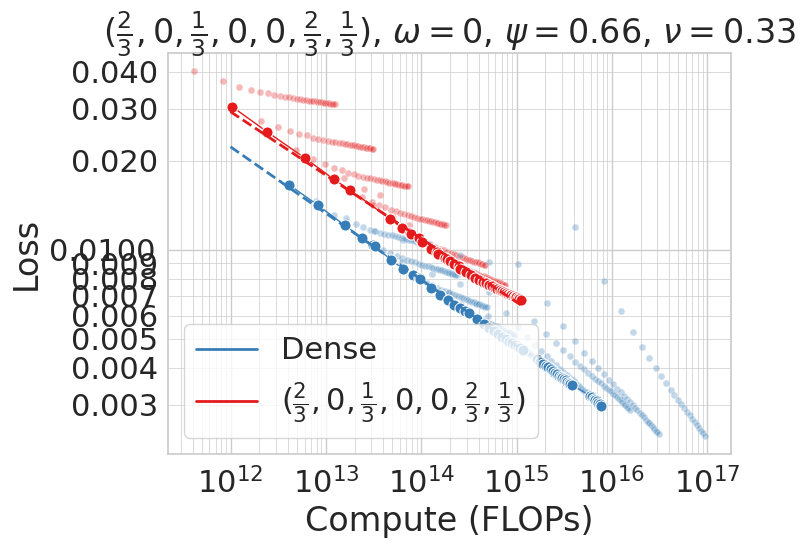

$(\frac{3}{4},0,\frac{1}{4},\frac{1}{4},0,\frac{3}{4},\frac{1}{4})$


/tmp/ipykernel_12086/3010493432.py:65: UserWarning: 
The palette list has fewer values (1) than needed (180) and will cycle, which may produce an uninterpretable plot.
  ax = sns.lineplot(
/tmp/ipykernel_12086/3010493432.py:80: UserWarning: 
The palette list has fewer values (1) than needed (293) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


<Figure size 800x600 with 0 Axes>

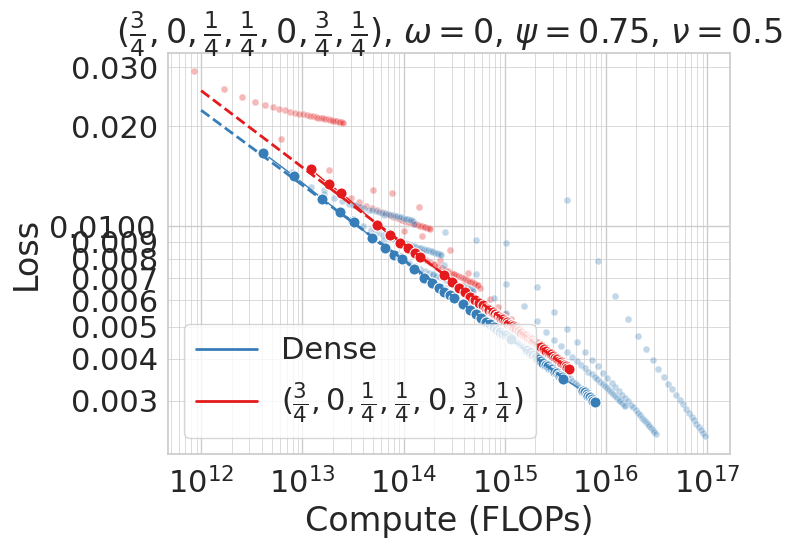

$(\frac{1}{4},0,\frac{3}{4},\frac{1}{4},0,\frac{3}{4},\frac{1}{4})$


/tmp/ipykernel_12086/3010493432.py:65: UserWarning: 
The palette list has fewer values (1) than needed (180) and will cycle, which may produce an uninterpretable plot.
  ax = sns.lineplot(
/tmp/ipykernel_12086/3010493432.py:80: UserWarning: 
The palette list has fewer values (1) than needed (293) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


<Figure size 800x600 with 0 Axes>

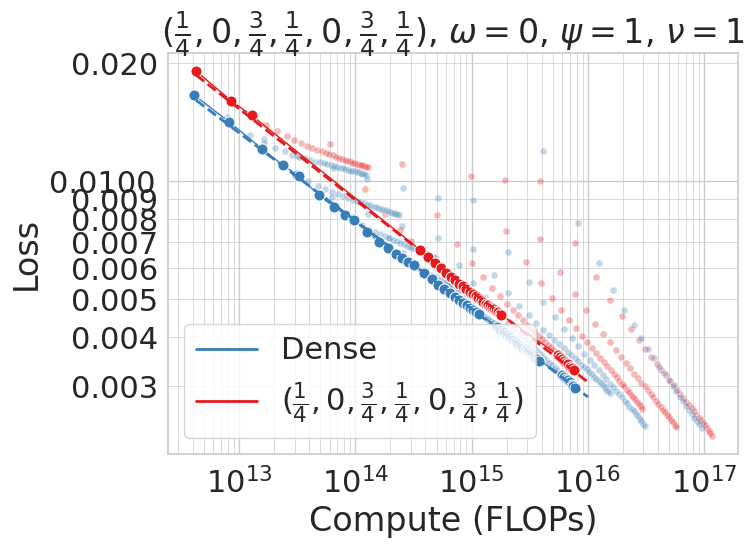

In [3]:
sns.set(style="whitegrid", font_scale=2.0, rc={"lines.linewidth": 3.0})
MIN_STEP = 1e3
MAX_STEP = 3e5

MIN_COMPUTE = 1e12
MAX_COMPUTE = 1e16
MIN_LOSS = 0

fit = True

# set palette
sns.set_palette("Set1")
dense_color = "C1"
struct_color = "C0"


dense_hist_df, dense_pareto_df, dense_slope, dense_intercept, dense_slope_err, dense_intercept_err = get_history_df(
    dense_runs, min_step=MIN_STEP, max_step=MAX_STEP, min_compute=MIN_COMPUTE, max_compute=MAX_COMPUTE, fit=fit, min_loss=MIN_LOSS
)
dense_runs["expo"] = dense_slope
dense_runs["const"] = dense_intercept
dense_runs["expo_err"] = dense_slope_err
dense_runs["const_err"] = dense_intercept_err

structs = ["Dense"]
vecs = ["Dense"]
expos = [dense_slope]
expo_errs = [dense_slope_err]
consts = [dense_intercept]
const_errs = [dense_intercept_err]
pareto_fronts = [dense_pareto_df]

for struct in ein_runs["struct"].unique():
    df = ein_runs[ein_runs["struct"] == struct]
    # skip if not at least two runs
    if len(df) < 2:
        continue
    vec = ein_runs[ein_runs["struct"] == struct].iloc[0]["vec"]
    vecs.append(vec)
    plt.figure(dpi=100, figsize=(8, 6))
    print(struct)

    try:
        hist_df, pareto_df, expo, const, expo_err, const_err = get_history_df(
            df, min_step=MIN_STEP, max_step=MAX_STEP, min_compute=MIN_COMPUTE, max_compute=MAX_COMPUTE, fit=fit, min_loss=MIN_LOSS
        )
    except:
        print(f"Failed {struct}")
        continue
    pareto_fronts.append(pareto_df)
    ein_runs.loc[ein_runs["struct"] == struct, "expo"] = expo
    ein_runs.loc[ein_runs["struct"] == struct, "const"] = const
    ein_runs.loc[ein_runs["struct"] == struct, "expo_err"] = expo_err
    ein_runs.loc[ein_runs["struct"] == struct, "const_err"] = const_err

    structs.append(struct)
    expos.append(expo)
    expo_errs.append(expo_err)
    consts.append(const)
    const_errs.append(const_err)

    plt.figure(dpi=100, figsize=(8, 6))

    # plot data
    ax = sns.lineplot(
        data=hist_df,
        x="compute",
        y="loss",
        hue="compute",
        style="n_layer",
        markers=True,
        alpha=0.3,
        palette=[struct_color],
        linewidth=1,
        legend=False,
        linestyle="-",
        markersize=5,
        errorbar=None,
    )
    sns.lineplot(
        data=dense_hist_df,
        x="compute",
        y="loss",
        hue="compute",
        style="n_layer",
        markers=True,
        alpha=0.3,
        palette=[dense_color],
        linewidth=1,
        legend=False,
        linestyle="-",
        markersize=5,
        errorbar=None,
    )

    # plot pareto front
    sns.lineplot(
        data=pareto_df,
        x="compute",
        y="loss",
        hue="struct",
        style="struct",
        markers=True,
        alpha=1,
        palette=[struct_color],
        linewidth=1,
        legend=False,
        linestyle="-",
        markersize=8,
        errorbar=None,
    )
    sns.lineplot(
        data=dense_pareto_df,
        x="compute",
        y="loss",
        hue="struct",
        style="struct",
        markers=True,
        alpha=1,
        palette=[dense_color],
        linewidth=1,
        legend=False,
        linestyle="-",
        markersize=8,
        errorbar=None,
    )

    ax.grid(which="minor", axis="y", linestyle="-", linewidth=0.5)
    ax.grid(which="minor", axis="x", linestyle="-", linewidth=0.5)

    # plot fits
    if fit:
        x_min = max(MIN_COMPUTE, min(hist_df["compute"]))
        x_max = min(MAX_COMPUTE, max(hist_df["compute"]))
        x = np.linspace(x_min, x_max, 100)
        y = np.exp(-dense_slope * np.log(x) + dense_intercept)
        plt.plot(x, y, color=dense_color, linestyle="--", linewidth=2, alpha=1)
        y = np.exp(-expo * np.log(x) + const)
        plt.plot(x, y, color=struct_color, linestyle="--", linewidth=2, alpha=1)

    plt.plot([], [], color=dense_color, linestyle="-", linewidth=2, alpha=1, label=rf"Dense")
    plt.plot([], [], color=struct_color, linestyle="-", linewidth=2, alpha=1, label=rf"{struct}")
    plt.ylabel("Loss")
    plt.xlabel("Compute (FLOPs)")
    plt.yscale("log")
    plt.xscale("log")

    plt.gca().yaxis.set_major_formatter(ScalarFormatter())
    plt.gca().yaxis.set_minor_formatter(ScalarFormatter())
    # plt.yticks([1e-2, 1e-3], labels=["$10^{-2}$", "$10^{-3}$"])
    # plt.ylim(2.75, 3.25)
    # plt.xlim(5e13, 5e17)

    plt.legend(loc="lower left")
    plt.title(rf"{struct}, $\omega={vec_to_omega(vec):.2g}$, $\psi={vec_to_psi(vec):.2g}$, $\nu={vec_to_nu(vec):.2g}$")
    plt.tight_layout()
    # plt.savefig(f"./figures/{plot_name}_{vec}_compute.pdf", bbox_inches="tight")
    plt.show()



In [4]:
from pathlib import Path
out = Path("./figures/mlp/omega.pdf")
out.parent.mkdir(parents=True, exist_ok=True)

/tmp/ipykernel_12086/3570337512.py:24: UserWarning: 
The markers list has fewer values (1) than needed (21) and will cycle, which may produce an uninterpretable plot.
  ax = sns.lineplot(


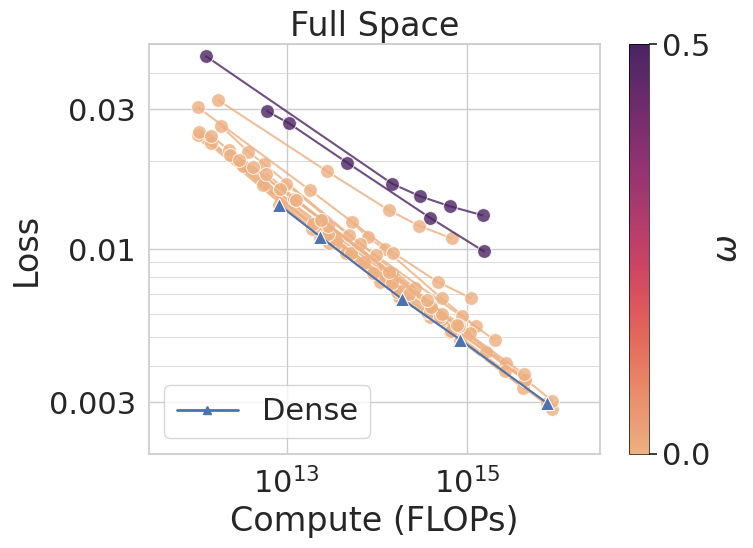

In [5]:


def select_uniform_log_steps(df, num_points=5):
    if len(df) <= num_points:
        return df
    log_steps = np.log(df["step"])
    min_log_step = np.min(log_steps)
    max_log_step = np.max(log_steps)

    uniform_log_steps = np.linspace(min_log_step, max_log_step, num_points)
    indices = np.searchsorted(log_steps, uniform_log_steps)
    indices = np.clip(indices, 0, len(df) - 1)

    return df.iloc[indices]


pareto_fronts = [select_uniform_log_steps(df, num_points=5) for df in pareto_fronts]
dense_pareto_df = select_uniform_log_steps(dense_pareto_df, num_points=5)

df = pd.concat(pareto_fronts)
dense_color = "C1"
# Create a custom colormap
cmap = sns.color_palette("flare", as_cmap=True)

plt.figure(dpi=100, figsize=(8, 6))
ax = sns.lineplot(
    data=df,
    x="compute",
    y="loss",
    hue="omega",
    style="struct",
    dashes=False,
    markers="o",
    markersize=10,
    alpha=0.8,
    palette=cmap,
    linewidth=1.5,
    legend=False,
)
ax.grid(which="minor", axis="y", linestyle="-", linewidth=0.5)
ax.grid(which="minor", axis="x", linestyle="-", linewidth=0.5)
sns.lineplot(
    data=dense_pareto_df,
    x="compute",
    y="loss",
    style="struct",
    marker="^",
    alpha=1,
    color="b",
    linewidth=1.5,
    legend=False,
    linestyle="-",
    markersize=10,
)
# add dense legend
plt.plot([], [], color="b", marker="^", linestyle="-", linewidth=2, alpha=1, label=rf"Dense")
plt.legend(loc="lower left")
plt.ylabel("Loss")
plt.xlabel("Compute (FLOPs)")
plt.yscale("log")
plt.xscale("log")


plt.ylim(0.002, 0.05)
plt.xlim(3e11, 3e16)
plt.yticks([3e-2, 1e-2, 3e-3], labels=["0.03", "0.01", "0.003"])
# plt.gca().yaxis.set_major_formatter(ScalarFormatter())
# plt.gca().yaxis.set_minor_formatter(ScalarFormatter())

# Add a colorbar
norm = Normalize(df["omega"].min(), df["omega"].max())
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r"$\omega$", labelpad=0)

# Adjust the colorbar ticks and labels
cbar.set_ticks([df["omega"].min(), df["omega"].max()])
cbar.set_ticklabels([f'{df["omega"].min():.1f}', f'{df["omega"].max():.1f}'])

# Add a frame to the colorbar
cbar.outline.set_visible(True)
cbar.outline.set_linewidth(0.5)
cbar.outline.set_edgecolor("black")
plt.title("Full Space")
plt.tight_layout()
plt.savefig(f"./figures/mlp/omega.pdf", bbox_inches="tight")
plt.show()

/tmp/ipykernel_12086/1564630330.py:5: UserWarning: 
The markers list has fewer values (1) than needed (19) and will cycle, which may produce an uninterpretable plot.
  ax = sns.lineplot(data=df, x='compute', y='loss', hue='psi', style='struct', dashes=False, markers='o', markersize=10, alpha=0.8, palette=cmap, linewidth=1.5, legend=False)


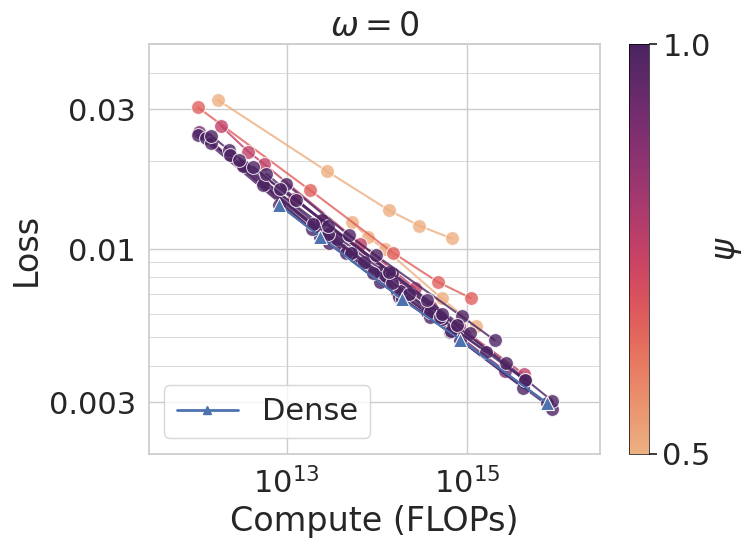

/tmp/ipykernel_12086/1564630330.py:45: UserWarning: 
The markers list has fewer values (1) than needed (12) and will cycle, which may produce an uninterpretable plot.
  ax = sns.lineplot(data=df, x='compute', y='loss', hue='nu', style='struct', dashes=False, markers='o', markersize=10, alpha=0.8, palette=cmap, linewidth=1.5, legend=False)


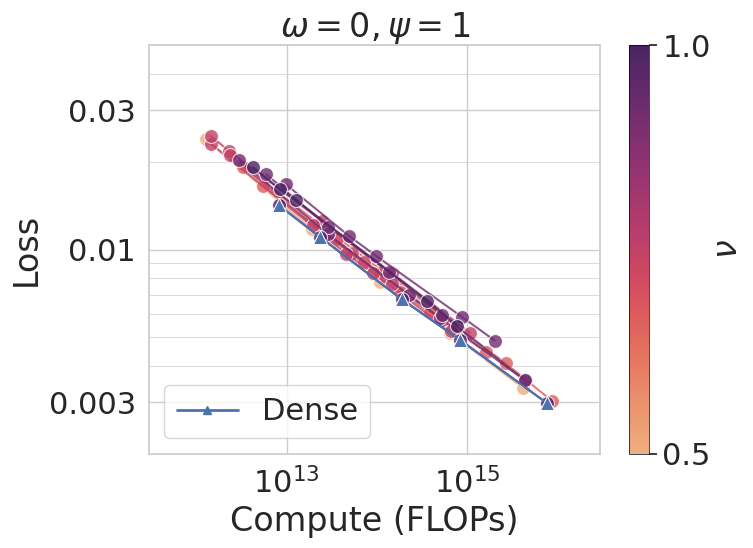

In [6]:
df = pd.concat(pareto_fronts)
df = df[df['omega'] == 0]

plt.figure(dpi=100, figsize=(8, 6))
ax = sns.lineplot(data=df, x='compute', y='loss', hue='psi', style='struct', dashes=False, markers='o', markersize=10, alpha=0.8, palette=cmap, linewidth=1.5, legend=False)
ax.grid(which='minor', axis='y', linestyle='-', linewidth=0.5)
ax.grid(which='minor', axis='x', linestyle='-', linewidth=0.5)
sns.lineplot(data=dense_pareto_df, x='compute', y='loss', style='struct', marker='^', alpha=1, color='b', linewidth=1.5, legend=False, linestyle='-', markersize=10)
plt.plot([], [], color='b', marker='^', linestyle='-', linewidth=2, alpha=1, label=rf'Dense')
plt.legend(loc='lower left')
plt.ylabel('Loss')
plt.xlabel('Compute (FLOPs)')
plt.yscale('log')
plt.xscale('log')

# plt.gca().yaxis.set_major_formatter(ScalarFormatter())
# plt.gca().yaxis.set_minor_formatter(ScalarFormatter())
plt.ylim(0.002, 0.05)
plt.xlim(3e11, 3e16)
plt.yticks([3e-2, 1e-2, 3e-3], labels=["0.03", "0.01", "0.003"])

# Add a colorbar
norm = Normalize(df['psi'].min(), df['psi'].max())
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r'$\psi$', labelpad=0)

# Adjust the colorbar ticks and labels
cbar.set_ticks([df['psi'].min(), df['psi'].max()])
cbar.set_ticklabels([f'{df["psi"].min():.1f}', f'{df["psi"].max():.1f}'])

# Add a frame to the colorbar
cbar.outline.set_visible(True)
cbar.outline.set_linewidth(0.5)
cbar.outline.set_edgecolor('black')
plt.title(r'$\omega = 0$')
plt.tight_layout()
plt.savefig(f'./figures/mlp/psi.pdf', bbox_inches='tight')
plt.show()


df = df[df['psi'] == 1]
plt.figure(dpi=100, figsize=(8, 6))
ax = sns.lineplot(data=df, x='compute', y='loss', hue='nu', style='struct', dashes=False, markers='o', markersize=10, alpha=0.8, palette=cmap, linewidth=1.5, legend=False)
ax.grid(which='minor', axis='y', linestyle='-', linewidth=0.5)
ax.grid(which='minor', axis='x', linestyle='-', linewidth=0.5)
sns.lineplot(data=dense_pareto_df, x='compute', y='loss', style='struct', marker='^', alpha=1, color='b', linewidth=1.5, legend=False, linestyle='-', markersize=10)
plt.plot([], [], color='b', marker='^', linestyle='-', linewidth=2, alpha=1, label=rf'Dense')
plt.legend(loc='lower left')
plt.ylabel('Loss')
plt.xlabel('Compute (FLOPs)')
plt.yscale('log')
plt.xscale('log')

# plt.gca().yaxis.set_major_formatter(ScalarFormatter())
# plt.gca().yaxis.set_minor_formatter(ScalarFormatter())
plt.ylim(0.002, 0.05)
plt.xlim(3e11, 3e16)
plt.yticks([3e-2, 1e-2, 3e-3], labels=["0.03", "0.01", "0.003"])

# Add a colorbar
norm = Normalize(df['nu'].min(), df['nu'].max())
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r'$\nu$', labelpad=0)

# Adjust the colorbar ticks and labels
cbar.set_ticks([df['nu'].min(), df['nu'].max()])
cbar.set_ticklabels([f'{df["nu"].min():.1f}', f'{df["nu"].max():.1f}'])

# Add a frame to the colorbar
cbar.outline.set_visible(True)
cbar.outline.set_linewidth(0.5)
cbar.outline.set_edgecolor('black')

plt.title(r'$\omega=0, \psi = 1$')
plt.tight_layout()
plt.savefig(f'./figures/mlp/nu.pdf', bbox_inches='tight')
plt.show()

